In [ ]:
# Step 0 - Setup
!pip install -q xgboost imbalanced-learn

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

SEED = 42
np.random.seed(SEED)

print("Setup done. Libraries imported.")


Setup done. Libraries imported.


In [ ]:
from google.colab import files
import io

uploaded = files.upload()             # choose your CSV file from your computer
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded:", fname)


Saving synthetic_food_dataset_imbalanced.csv to synthetic_food_dataset_imbalanced.csv
Loaded: synthetic_food_dataset_imbalanced.csv


In [ ]:
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.isnull().sum())


Shape: (31700, 16)


,Calories,Protein,Fat,Carbs,Sugar,Fiber,Sodium,Cholesterol,Glycemic_Index,Water_Content,Serving_Size,Meal_Type,Preparation_Method,Is_Vegan,Is_Gluten_Free,Food_Name
0,290.463673,14.340084,14.152608,35.266644,4.828030,1.291432,647.553389,24.990309,81.575896,45.669118,197.570043,dinner,fried,False,False,Pizza
1,212.626748,4.080908,11.621584,23.218957,16.347814,0.130303,68.572414,34.301652,69.522492,49.854415,103.833510,snack,raw,False,True,Ice Cream
2,330.695408,14.326708,19.747680,29.479164,6.251137,0.794477,663.171859,34.816834,62.552384,40.132866,198.989367,snack,raw,False,False,Burger
3,198.070798,9.452445,5.475896,32.097878,2.984621,1.710468,300.749543,28.510998,68.688853,57.423461,135.714202,lunch,fried,False,True,Sushi
4,274.496228,6.099547,16.256002,29.756638,17.352958,1.465676,296.314958,15.403173,70.385059,33.170460,73.019474,snack,baked,False,False,Donut


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31700 entries, 0 to 31699
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Calories            31325 non-null  float64
 1   Protein             31325 non-null  float64
 2   Fat                 31325 non-null  float64
 3   Carbs               31325 non-null  float64
 4   Sugar               31325 non-null  float64
 5   Fiber               31325 non-null  float64
 6   Sodium              31325 non-null  float64
 7   Cholesterol         31325 non-null  float64
 8   Glycemic_Index      31325 non-null  float64
 9   Water_Content       31325 non-null  float64
 10  Serving_Size        31325 non-null  float64
 11  Meal_Type           31700 non-null  object 
 12  Preparation_Method  31700 non-null  object 
 13  Is_Vegan            31700 non-null  bool   
 14  Is_Gluten_Free      31700 non-null  bool   
 15  Food_Name           31700 non-null  object 
dtypes: b

None

,0
Calories,375
Protein,375
Fat,375
Carbs,375
Sugar,375
Fiber,375
Sodium,375
Cholesterol,375
Glycemic_Index,375
Water_Content,375


In [ ]:
target = 'Food_Name'
print("Unique target classes and counts:")
display(df[target].value_counts())

num_cols = ['Calories','Protein','Fat','Carbs','Sugar','Fiber','Sodium',
            'Cholesterol','Glycemic_Index','Water_Content','Serving_Size']
print("\nNumeric columns present in dataset:")
print([c for c in num_cols if c in df.columns])

# Summary stats
display(df[num_cols].describe().T)


Unique target classes and counts:


,count
Food_Name,
Pizza,6000
Burger,5000
Donut,4500
Pasta,4000
Sushi,3500
Ice Cream,3000
Steak,2000
Apple,1500
Banana,1200



Numeric columns present in dataset:
['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']


,count,mean,std,min,25%,50%,75%,max
Calories,31325.0,273.378441,111.457160,60.786204,210.301731,281.774249,329.821946,1289.956763
Protein,31325.0,9.523802,8.024212,0.000000,3.858307,9.091637,12.683957,81.761772
Fat,31325.0,12.476848,8.425834,0.000000,8.245636,11.574161,15.818611,88.619611
Carbs,31325.0,28.943200,12.668795,0.000000,25.098800,29.681430,34.635789,140.585537
Sugar,31325.0,8.543813,7.989075,0.000000,3.739656,5.500479,14.426303,78.548162
Fiber,31325.0,1.904044,1.779542,0.000000,0.741204,1.646608,2.668750,18.891993
Sodium,31325.0,335.387611,319.066106,0.000000,63.000654,292.525242,631.367901,2724.236846
Cholesterol,31325.0,26.865167,24.965067,0.000000,12.701920,23.285882,35.132214,260.149443
Glycemic_Index,31325.0,64.213509,25.390239,0.000000,59.984731,68.436204,75.464697,286.126400
Water_Content,31325.0,48.976592,20.738749,13.465039,38.994221,45.613748,52.399496,251.837472


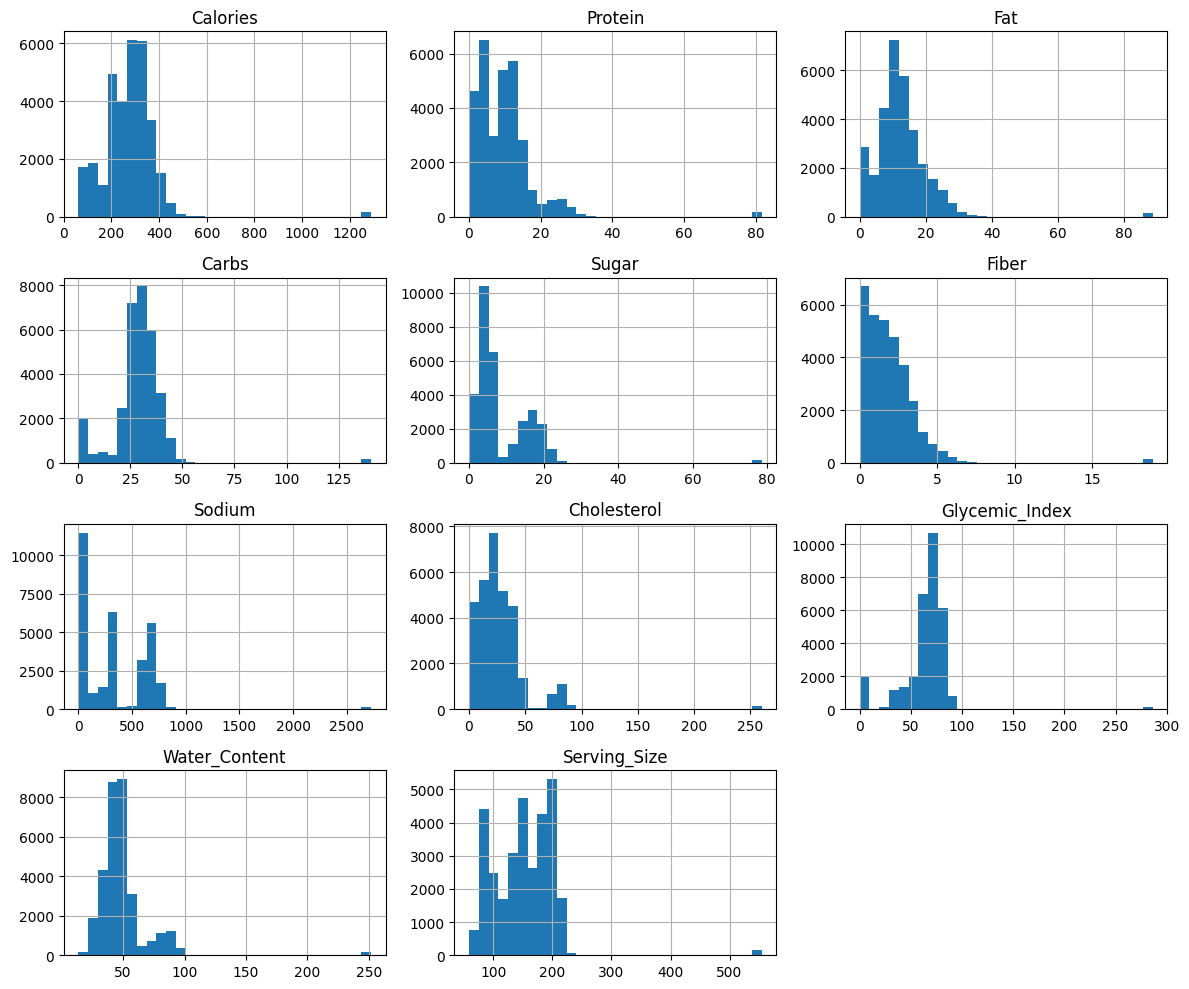

In [ ]:
# Histograms
df[num_cols].hist(figsize=(12,10), bins=30)
plt.tight_layout()
plt.show()

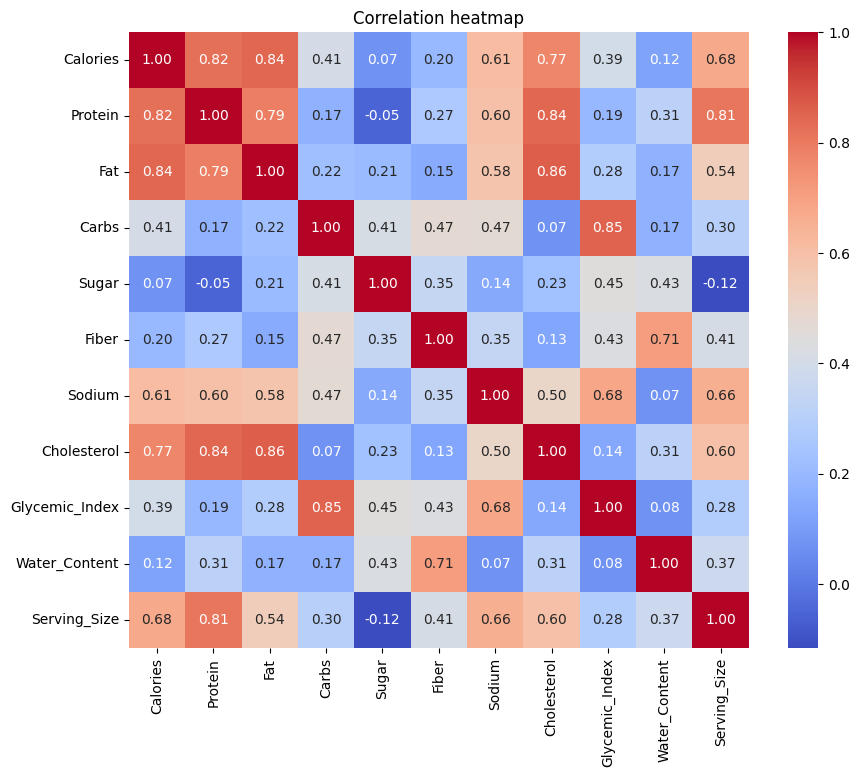

In [ ]:
# Correlation heatmap (numeric features)
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()

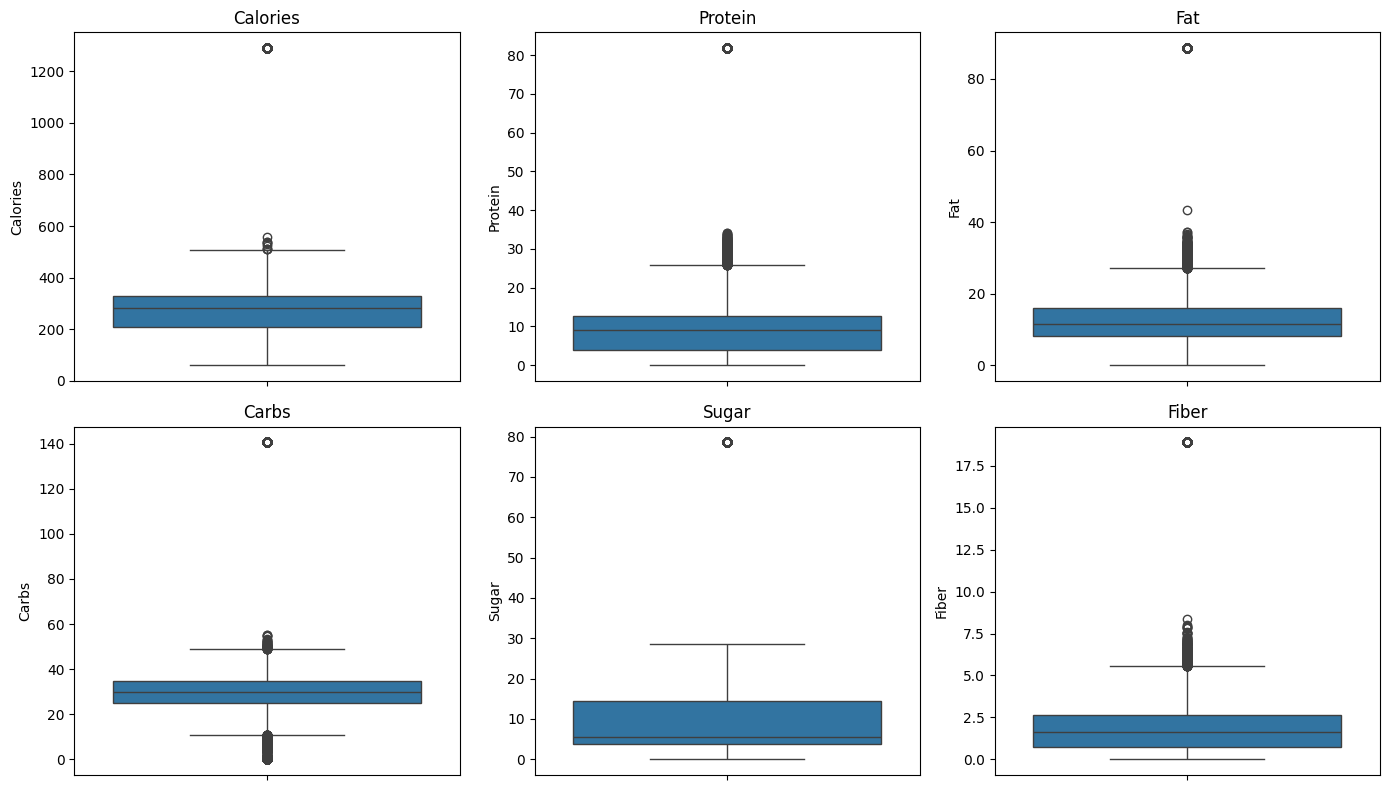

In [ ]:
# Boxplots for quick outlier view (one per row)
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols[:6], 1):
    plt.subplot(2,3,i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Data Preprocessing

In [ ]:
# Numeric imputation
num_present = [c for c in num_cols if c in df.columns]
imputer = SimpleImputer(strategy='median')
df[num_present] = imputer.fit_transform(df[num_present])

# Categorical impute (example: Preparation_Method)
if 'Preparation_Method' in df.columns:
    df['Preparation_Method'].fillna(df['Preparation_Method'].mode()[0], inplace=True)

# Target: if any missing (rare), fill with mode (you may prefer to drop instead)
df[target].fillna(df[target].mode()[0], inplace=True)

print("Missing values after imputation:")
display(df.isnull().sum())

Missing values after imputation:


/tmp/ipython-input-859670649.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preparation_Method'].fillna(df['Preparation_Method'].mode()[0], inplace=True)
/tmp/ipython-input-859670649.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

,0
Calories,0
Protein,0
Fat,0
Carbs,0
Sugar,0
Fiber,0
Sodium,0
Cholesterol,0
Glycemic_Index,0
Water_Content,0


In [ ]:
before = len(df)
df.drop_duplicates(inplace=True)
after = len(df)
print(f"Dropped {before-after} duplicate rows. New shape: {df.shape}")

Dropped 313 duplicate rows. New shape: (31387, 16)


In [ ]:
def cap_outliers_iqr(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return s.clip(lower, upper)

for col in num_present:
    df[col] = cap_outliers_iqr(df[col])

print("Outlier capping applied to numeric columns.")

Outlier capping applied to numeric columns.


Feature Selection

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define target
target = "Food_Name"

# Encode target
le = LabelEncoder()
df[target + "_enc"] = le.fit_transform(df[target])
y = df[target + "_enc"]

# Select only the important nutritional features
nutritional_features = [
    "Calories", "Protein", "Fat", "Carbs", "Sugar", "Fiber",
    "Sodium", "Cholesterol", "Glycemic_Index", "Water_Content", "Serving_Size"
]

X = df[nutritional_features]

print("Final feature columns:", X.columns.tolist())
print("X shape:", X.shape, "| y shape:", y.shape)


Final feature columns: ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']
X shape: (31387, 11) | y shape: (31387,)


Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (25109, 11) Test shape: (6278, 11)


Scale Nutritional Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling applied. Example scaled row:", X_train_scaled[0])


Scaling applied. Example scaled row: [-0.48907796 -0.73680826  1.30306726  0.39228614  1.92302496 -0.41265519
 -0.19804341 -0.36592149  0.75203963 -1.11356926 -1.42541565]


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9904428161834979

Classification Report:

              precision    recall  f1-score   support

       Apple       0.94      0.97      0.96       297
      Banana       0.98      0.96      0.97       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       1.00      0.99      0.99      1183
       Salad       0.99      0.99      0.99       199
       Steak       1.00      1.00      1.00       398
       Sushi       0.97      1.00      0.98       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = DecisionTreeClassifier(class_weight='balanced', random_state=SEED)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9855049378783052

Classification Report:

              precision    recall  f1-score   support

       Apple       0.95      0.99      0.97       297
      Banana       1.00      0.96      0.98       239
      Burger       0.98      0.96      0.97       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.97      0.98      0.98      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.98      0.99      0.98      6278
weighted avg       0.99      0.99      0.99      6278



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200, class_weight='balanced',
    random_state=SEED, n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Accuracy: 0.9923542529467984

Classification Report:

              precision    recall  f1-score   support

       Apple       0.96      0.99      0.97       297
      Banana       1.00      0.98      0.99       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.98      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

KNN Accuracy: 0.9918763937559733

Classification Report:

              precision    recall  f1-score   support

       Apple       1.00      0.98      0.99       297
      Banana       0.92      1.00      0.95       239
      Burger       0.99      0.98      0.99       988
       Donut       0.99      1.00      0.99       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      0.99      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced', probability=False, random_state=SEED)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

SVM Accuracy: 0.9934692577253903

Classification Report:

              precision    recall  f1-score   support

       Apple       0.96      0.99      0.98       297
      Banana       1.00      0.99      0.99       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       1.00      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       0.97      1.00      0.99       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



XGBoost

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='mlogloss',
    random_state=SEED, n_jobs=-1
)

xgb_clf.fit(X_train_scaled, y_train)
y_pred = xgb_clf.predict(X_test_scaled)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9928321121376235

Classification Report:

              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99       297
      Banana       1.00      0.97      0.99       239
      Burger       1.00      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       0.98      0.99      0.99       795
       Pizza       0.98      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=SEED)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Gradient Boosting Accuracy: 0.9925135393437401

Classification Report:

              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99       297
      Banana       1.00      0.98      0.99       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      0.99      1.00       893
   Ice Cream       0.96      1.00      0.98       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.98      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



Cross-validation (K-Fold) on training set

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("Cross-validation Macro-F1 scores:", scores)
print("Mean F1:", np.mean(scores))
print("Std deviation:", np.std(scores))

Cross-validation Macro-F1 scores: [0.99193715 0.99128604 0.98919217 0.99376802 0.98866332]
Mean F1: 0.9909693399865036
Std deviation: 0.0018625592059290051


In [ ]:
import pandas as pd

# Recreate results_df with your CV results
results_data = [
    ("XGBoost", 0.990969, 0.001863),
    ("GradientBoosting", 0.990859, 0.001606),
    ("SVM", 0.988864, 0.001629),
    ("KNN", 0.988860, 0.001613),
    ("LogisticRegression", 0.987305, 0.001842),
    ("RandomForest", 0.986608, 0.002089),
    ("DecisionTree", 0.981546, 0.002360),
]

results_df = pd.DataFrame(results_data, columns=["model", "f1_macro", "cv_f1_std"])

<Figure size 1000x500 with 0 Axes>

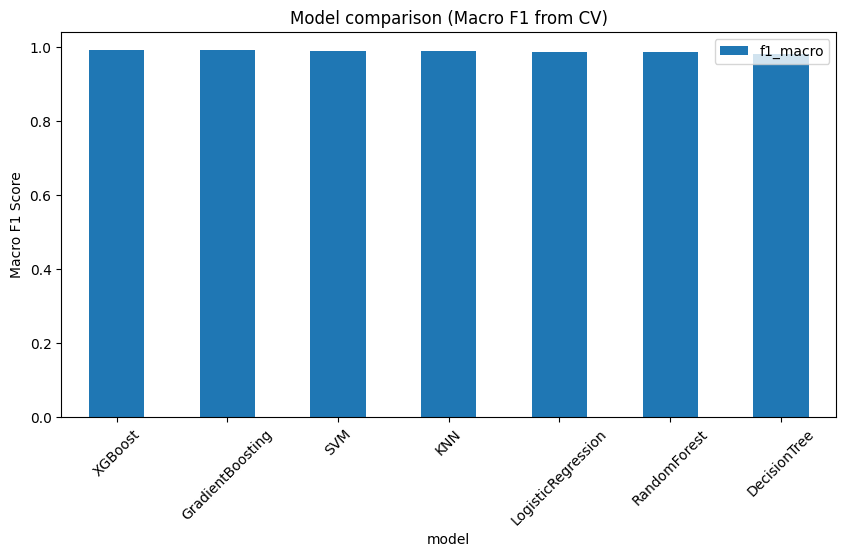

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
results_df.set_index('model')[['f1_macro']].plot(kind='bar', figsize=(10,5), rot=45)
plt.title("Model comparison (Macro F1 from CV)")
plt.ylabel("Macro F1 Score")
plt.show()

Data Imbalance using undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Before undersampling
print("Class distribution before undersampling:", Counter(y_train))

# Apply undersampling
rus = RandomUnderSampler(random_state=SEED)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# After undersampling
print("Class distribution after undersampling:", Counter(y_train_resampled))


Class distribution before undersampling: Counter({6: 4733, 2: 3950, 3: 3573, 5: 3180, 9: 2770, 4: 2374, 8: 1594, 0: 1187, 1: 954, 7: 794})
Class distribution after undersampling: Counter({0: 794, 1: 794, 2: 794, 3: 794, 4: 794, 5: 794, 6: 794, 7: 794, 8: 794, 9: 794})


RandomForest training after undersampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200, random_state=SEED, n_jobs=-1
)

rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Accuracy: 0.9926728257406817

Classification Report:

              precision    recall  f1-score   support

       Apple       0.96      0.99      0.98       297
      Banana       1.00      0.99      0.99       239
      Burger       0.99      0.98      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



In [ ]:
models = {
    "LogisticRegression": clf,
    "DecisionTree": clf,
    "RandomForest": rf,
    "KNN": knn,
    "SVM": svm,
    "XGBoost": xgb_clf,
    "GradientBoosting": gb
}

Best model on test set

In [ ]:
best_name = results_df.loc[0, 'model']
best_model = models[best_name]
print("Best model:", best_name)

y_pred_best = best_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification report (full):\n")
print(classification_report(y_test, y_pred_best,
target_names=le.classes_))

Best model: XGBoost
Accuracy: 0.9928321121376235

Classification report (full):

              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99       297
      Banana       1.00      0.97      0.99       239
      Burger       1.00      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       0.98      0.99      0.99       795
       Pizza       0.98      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



Confusion Matrix

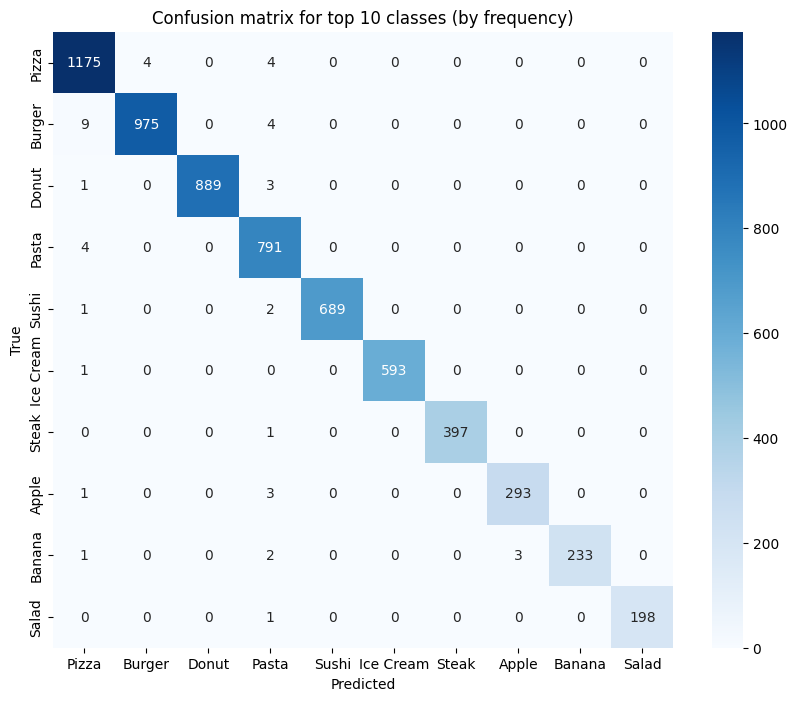

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

K = 10  # change if you want fewer/more
unique, counts = np.unique(y_test, return_counts=True)
freq = pd.Series(counts, index=unique)
topk = freq.sort_values(ascending=False).index[:K]   # encoded labels
topk_names = le.inverse_transform(topk)

# mask only test samples whose true label is in topk
mask = np.isin(y_test, topk)
y_test_masked = y_test[mask]
y_pred_masked = y_pred_best[mask]

cm_topk = confusion_matrix(y_test_masked, y_pred_masked, labels=topk)

plt.figure(figsize=(10,8))
sns.heatmap(cm_topk, annot=True, fmt='d', xticklabels=topk_names, yticklabels=topk_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix for top {K} classes (by frequency)")
plt.show()

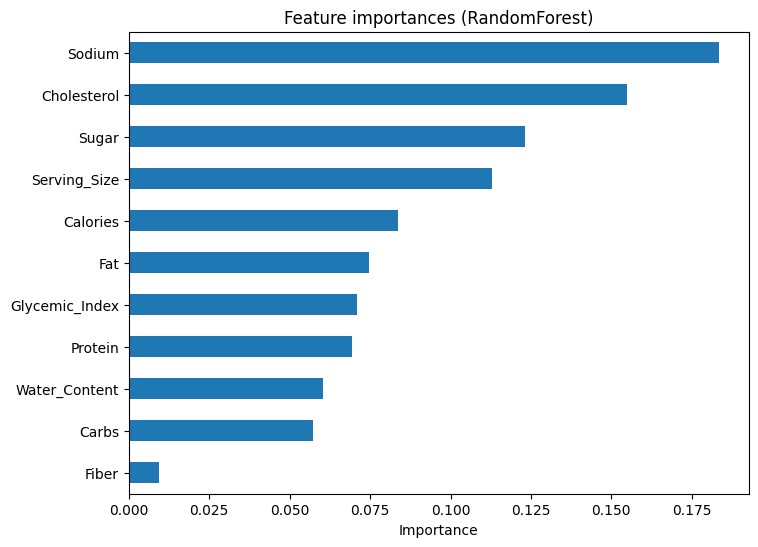

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:37:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


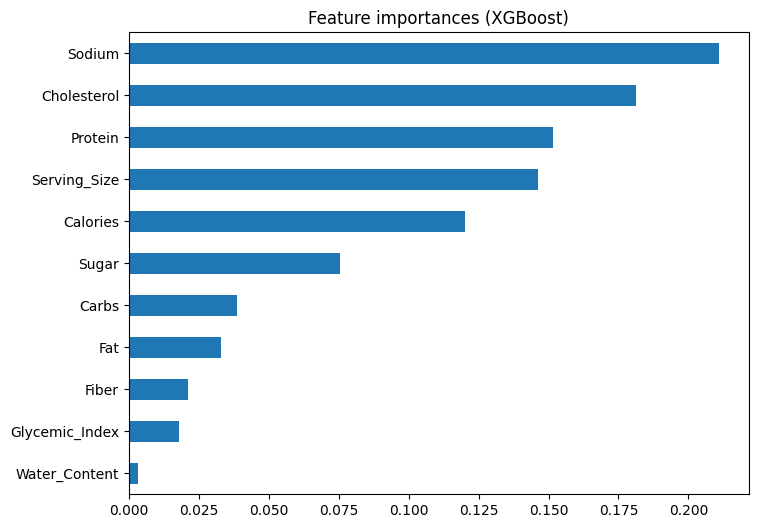

In [ ]:
# Step 16 - Feature importances from RandomForest
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=SEED, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=nutritional_features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Feature importances (RandomForest)")
plt.xlabel("Importance")
plt.show()

# If you want XGBoost importances:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)
xgb_clf.fit(X_train_scaled, y_train)
xgb_imp = pd.Series(xgb_clf.feature_importances_, index=nutritional_features).sort_values(ascending=True)
plt.figure(figsize=(8,6))
xgb_imp.plot(kind='barh')
plt.title("Feature importances (XGBoost)")
plt.show()

In [ ]:
# Step 18 - Small GridSearch for RandomForest
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}

gs = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
# Choose training data for gridsearch:
train_for_gs_X, train_for_gs_y = (X_res, y_res) if 'X_res' in globals() else (X_train_scaled, y_train)
gs.fit(train_for_gs_X, train_for_gs_y)

print("Best params:", gs.best_params_)
print("Best CV score (f1_macro):", gs.best_score_)
best_rf = gs.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'max_depth': None, 'n_estimators': 200}
Best CV score (f1_macro): 0.9914432267012551


In [ ]:
import numpy as np

# [Calories, Protein, Fat, Carbs, Sugar, Fiber, Sodium, Cholesterol, Glycemic_Index, Water_Content, Serving_Size]
sample_features = np.array([[198, 9, 5, 33, 2, 1, 300, 30, 70, 57, 130]])

# Scale your features using the same scaler used during training
sample_scaled = scaler.transform(sample_features)

# Predict food name
predicted_class = xgb_clf.predict(sample_scaled)[0]

# Decode numeric label back to actual Food Name
predicted_food = le.inverse_transform([predicted_class])[0]

print("Predicted Food Name:", predicted_food)

Predicted Food Name: Sushi


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
